In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from crime_categories import crime_categories

### Clean the data

In [3]:
la_crime = "la_crime_2020_2024_reduced.csv"
crime_df = pd.read_csv(la_crime)

la_weather = "la_weather_2020_2024_cleaned.csv"
weather_df = pd.read_csv(la_weather)

# Columns to drop
drop_cols = ["DR_NO", "Rpt Dist No", "Mocodes", "Premis Cd", "Status", "AREA", "Part 1-2", "Crm Cd",
             "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", "Crm Cd 4", "Cross Street", "Weapon Used Cd", "Weapon Desc", 
             "LOCATION"]

crime_df = crime_df.drop(drop_cols, axis=1)

# Rename the columns accordingly
cols_rename = {
    "Date Rptd":"DATE_REPORTED",
    "DATE OCC":"DATE_OCCURRED",
    "TIME OCC":"TIME_OCCURRED",
    "AREA NAME":"AREA_NAME",
    "Crm Cd Desc":"CRIME_DESCRIPTION",
    "Vict Age":"VICTIM_AGE",
    "Vict Sex":"VICTIM_SEX",
    "Vict Descent":"VICTIM_DESCENT",
    "Premis Desc":"PREMISE_DESCRIPTION",
    "Status Desc":"STATUS",
}
crime_df = crime_df.rename(columns=cols_rename)

# Drop remaining rows with missing values
crime_df = crime_df.dropna()

# Convert military format time to standard time object
crime_df["TIME_OCCURRED"] = crime_df["TIME_OCCURRED"].astype(str).str.zfill(4)
crime_df["TIME_OCCURRED"] = crime_df["TIME_OCCURRED"].str[:2] + ":" + crime_df["TIME_OCCURRED"].str[2:]
crime_df["TIME_OCCURRED"] = pd.to_datetime(crime_df["TIME_OCCURRED"], format="%H:%M")

# Convert date columns to datetime objects
crime_df["DATE_OCCURRED"] = pd.to_datetime(crime_df["DATE_OCCURRED"], format="%m/%d/%Y %H:%M:%S %p")
crime_df["DATE_REPORTED"] = pd.to_datetime(crime_df["DATE_REPORTED"], format="%m/%d/%Y %H:%M:%S %p")

# Filter out rows with invalid geographical coordinates
crime_df = crime_df[(crime_df["LAT"] != 0) & (crime_df["LON"] != 0)]

# Filter out rows with invalid victim ages
crime_df = crime_df[crime_df["VICTIM_AGE"] > 0]

# Filter out rows after January 2024 
crime_df = crime_df[crime_df["DATE_OCCURRED"] < pd.to_datetime("2024-01-01")]

# Clean weather data
weather_df.rename(str.upper, axis="columns", inplace=True)
weather_df["DATETIME"] = pd.to_datetime(weather_df["DATETIME"])


### Feature Extraction


In [4]:

# Hour of the day
crime_df["HOUR"] = crime_df["TIME_OCCURRED"].dt.hour

# Month, Year
crime_df["YEAR_MONTH"] = crime_df["DATE_OCCURRED"].dt.to_period("M")

# Time to report
crime_df["TIME_TO_REPORT"] = crime_df["DATE_REPORTED"] - crime_df["DATE_OCCURRED"]

# Only Attempt
crime_df["ATTEMPT"] = crime_df["CRIME_DESCRIPTION"].str.contains("ATTEMPT")



# Format dates to be more readable
crime_df["DATE_OCCURRED"] = crime_df["DATE_OCCURRED"].dt.date
crime_df["DATE_REPORTED"] = crime_df["DATE_REPORTED"].dt.date
crime_df["TIME_OCCURRED"] = crime_df["TIME_OCCURRED"].dt.time

# Crime Category
crime_categories_inverse = {crime: category for category, crimes in crime_categories.items() for crime in crimes}
crime_df["CRIME_CATEGORY"] = crime_df["CRIME_DESCRIPTION"].map(crime_categories_inverse)

# Join crime and weather data
crime_per_date = crime_df.groupby("DATE_OCCURRED").size().reset_index(name="CRIME_COUNT")

weather_df.rename(str.upper, axis="columns", inplace=True)
weather_df["DATETIME"] = pd.to_datetime(weather_df["DATETIME"]).dt.date

crime_weather_joined = pd.merge(crime_per_date, weather_df, how="inner", left_on="DATE_OCCURRED", right_on="DATETIME").drop("DATETIME", axis=1)
crime_weather_joined["DATE_OCCURRED"] = pd.to_datetime(crime_weather_joined["DATE_OCCURRED"])

crime_weather_joined["CRIME_COUNT"] = crime_weather_joined["CRIME_COUNT"].rolling(30).mean()
crime_weather_joined["TEMP"] = crime_weather_joined["TEMP"].rolling(30).mean()

### Discovering the Data

In [5]:
# Crime Category Proportions (top 5)
category_proportions = crime_df["CRIME_CATEGORY"].value_counts(normalize=True).head(5)

# How differently are men and women affected by different crime categories?
sex_per_category = crime_df.groupby("CRIME_CATEGORY")["VICTIM_SEX"].value_counts(normalize=True).unstack().apply(lambda x: x*100).filter(["M","F","X"], axis=1).sort_values(by="M", ascending=False)

# Average time to report per crime category
category_avg_ttr = crime_df.groupby("CRIME_CATEGORY")["TIME_TO_REPORT"].mean().dt.total_seconds().apply(lambda x: x/(60*60*24)).sort_values()

# Attempted crimes per category (top 5 attempted)
category_attempted = crime_df.groupby("CRIME_CATEGORY")["ATTEMPT"].value_counts(normalize=True).unstack().fillna(0).apply(lambda x: x*100).sort_values(by=True, ascending=False).rename(columns={True:"ATTEMPTED", False:"COMMITTED"}).head(6)

# Distribution of TTR per crime category
ttr_evolution = crime_df.groupby("YEAR_MONTH")["TIME_TO_REPORT"].mean().dt.total_seconds().apply(lambda x: x/(60*60*24)).rolling(7).mean().iloc[7:].to_frame("TIME_TO_REPORT").reset_index()

# Distribution of crime categories per hour of the day
hour_distribution = crime_df.groupby("HOUR")["CRIME_CATEGORY"].value_counts().unstack().filter(category_proportions.index, axis=1).sort_values(by="CRIME_CATEGORY", ascending=True, axis=1)

# crime per area (top 10)
crime_per_area = crime_df["AREA_NAME"].value_counts(normalize=True).head(10)

# crime categories per area
category_per_area = crime_df.groupby("AREA_NAME")["CRIME_CATEGORY"].value_counts().unstack().filter(category_proportions.index, axis=1).filter(crime_per_area.index, axis=0).sort_values(by="CRIME_CATEGORY", ascending=True, axis=1)

# crime per descent
descents = crime_df.groupby(["DATE_OCCURRED","VICTIM_DESCENT"]).size().unstack("VICTIM_DESCENT")
descents = descents.dropna(axis=1, thresh=0.95*len(descents)).rolling(20).mean()


### Visualize the Data

C:\Users\Saman\AppData\Local\Temp\ipykernel_17720\266551154.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30, ha='right')
C:\Users\Saman\AppData\Local\Temp\ipykernel_17720\266551154.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,2].set_yticklabels(ax[0,2].get_yticklabels(), rotation=45, ha='right')


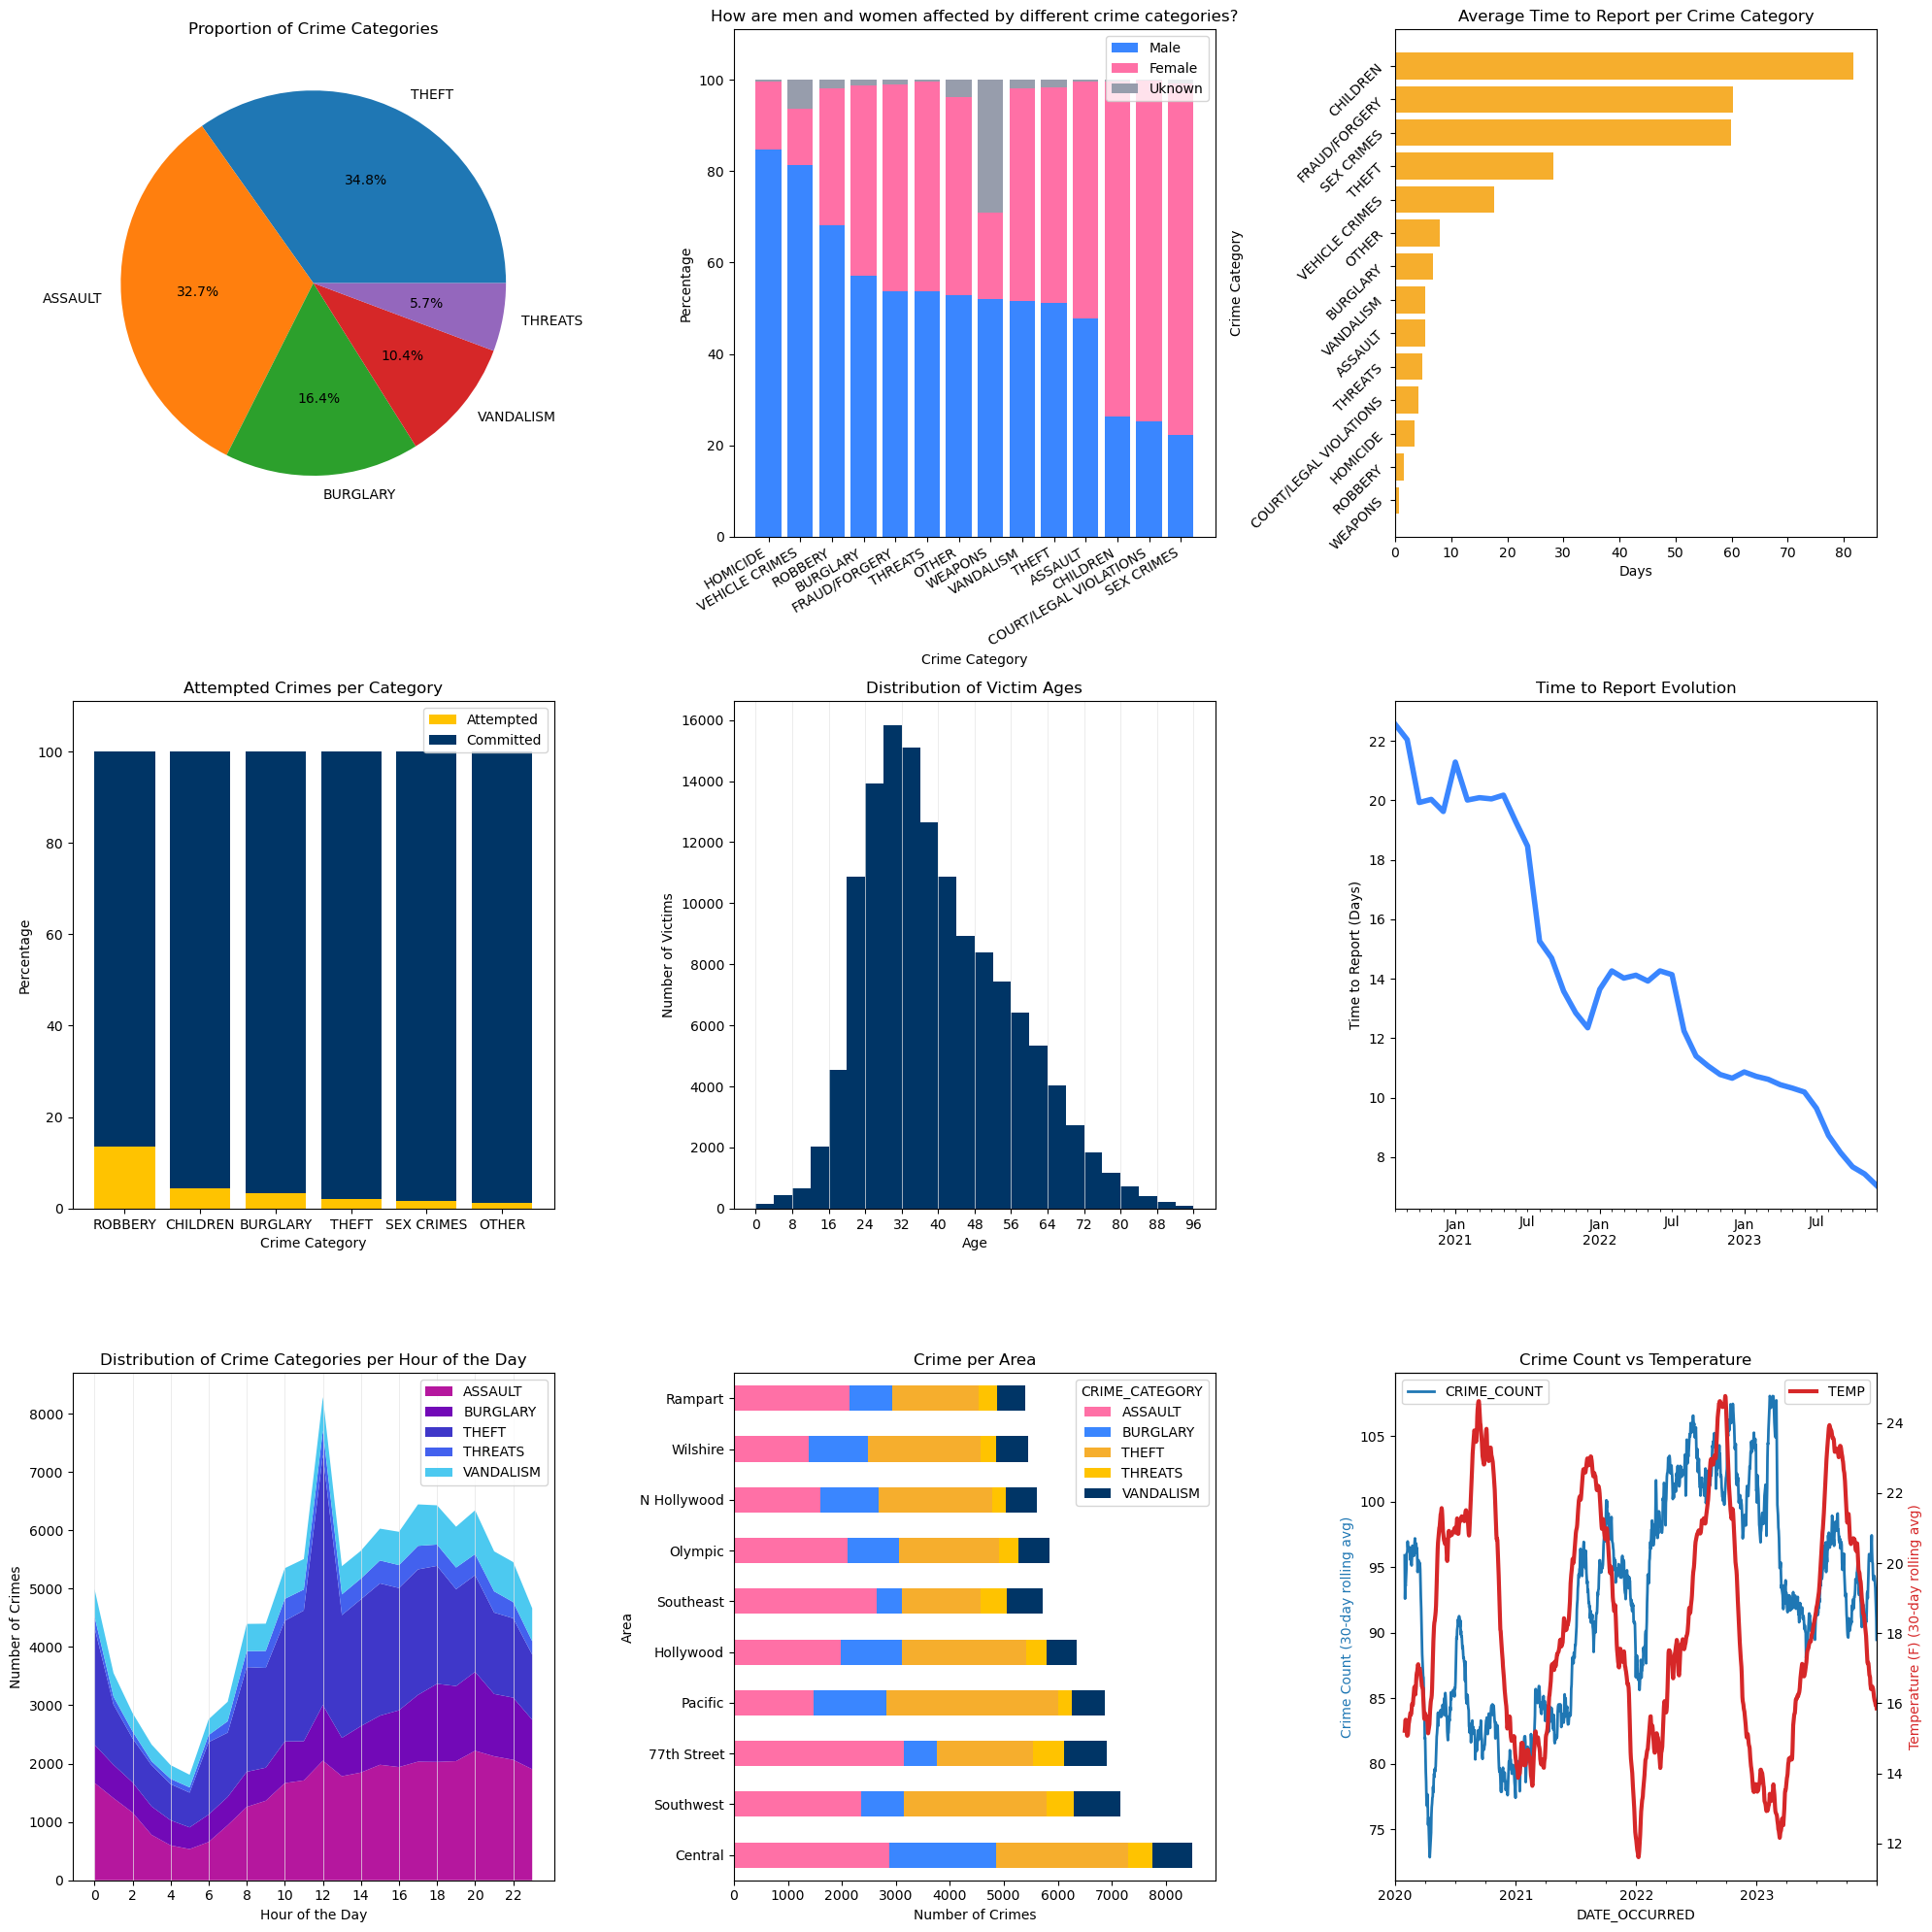

In [6]:

fig, ax = plt.subplots(3,3)
fig.set_size_inches(20, 20)

ax[0,0].set_title("Proportion of Crime Categories")
ax[0,0].pie(category_proportions, labels=category_proportions.index, autopct="%1.1f%%")

ax[0,1].set_title("How are men and women affected by different crime categories?")
ax[0,1].bar(sex_per_category.index, sex_per_category["M"], color="#3a86ff")
ax[0,1].bar(sex_per_category.index, sex_per_category["F"], bottom=sex_per_category["M"], color="#ff70a6")
ax[0,1].bar(sex_per_category.index, sex_per_category["X"], bottom=sex_per_category["F"]+sex_per_category["M"], color="#979dac")
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30, ha='right')
ax[0,1].margins(y=0.11)
ax[0,1].legend(["Male","Female","Uknown"],loc="upper right")
ax[0,1].set_ylabel("Percentage")
ax[0,1].set_xlabel("Crime Category")

ax[0,2].set_title("Average Time to Report per Crime Category")
ax[0,2].barh(category_avg_ttr.index, category_avg_ttr, color="#f6ae2d")
ax[0,2].set_xlabel("Days")
ax[0,2].set_ylabel("Crime Category")
ax[0,2].set_yticklabels(ax[0,2].get_yticklabels(), rotation=45, ha='right')

ax[1,0].set_title("Attempted Crimes per Category")
ax[1,0].bar(category_attempted.index, category_attempted["ATTEMPTED"], color="#ffc300")
ax[1,0].bar(category_attempted.index, category_attempted["COMMITTED"], bottom=category_attempted["ATTEMPTED"], color="#003566")
ax[1,0].set_xlabel("Crime Category")
ax[1,0].set_ylabel("Percentage")
ax[1,0].margins(y=0.11)
ax[1,0].legend(["Attempted","Committed"], loc="upper right")

ax[1,1].set_title("Distribution of Victim Ages")
ax[1,1].hist(x=crime_df["VICTIM_AGE"], bins=range(0,100,4), color="#003566")
ax[1,1].grid(True, axis="x", linewidth=.5, linestyle="-", color="#e5e5e5")
ax[1,1].set_xlabel("Age")
ax[1,1].set_ylabel("Number of Victims")
ax[1,1].set_xticks(np.arange(0,100,8))

ax[1,2].set_title("Time to Report Evolution")
ttr_evolution.plot(x="YEAR_MONTH", y="TIME_TO_REPORT", ax=ax[1,2], color="#3a86ff", ylabel="Time to Report (Days)", xlabel="", legend=False, linewidth=4)

ax[2,0].set_title("Distribution of Crime Categories per Hour of the Day")
ax[2,0].stackplot(hour_distribution.index, hour_distribution.T, labels=hour_distribution.columns, colors=["#b5179e", "#7209b7", "#3f37c9", "#4361ee", "#4cc9f0"])
ax[2,0].set_xlabel("Hour of the Day")
ax[2,0].set_xticks(np.arange(0,24,2))
ax[2,0].set_ylabel("Number of Crimes")
ax[2,0].legend(loc="upper right")
ax[2,0].grid(True, axis="x", linewidth=.5, linestyle="-", color="#e5e5e5")

ax[2,1].set_title("Crime per Area")
category_per_area.plot(kind="barh", stacked=True, ax=ax[2,1], color=["#ff70a6", "#3a86ff", "#f6ae2d", "#ffc300", "#003566"], ylabel="Area", xlabel="Number of Crimes", legend=True)

ax[2,2].set_title("Crime Count vs Temperature")
ax[2,2].set_xlabel("Date")
ax[2,2].set_ylabel("Crime Count (30-day rolling avg)", color="tab:blue")
ax2 = ax[2,2].twinx()
ax2.set_ylabel("Temperature (F) (30-day rolling avg)", color="tab:red")

crime_weather_joined.plot(y="CRIME_COUNT", x="DATE_OCCURRED", ax=ax[2,2], color="tab:blue", linewidth=2)
crime_weather_joined.plot(y="TEMP", x="DATE_OCCURRED", ax=ax2, color="tab:red", linewidth=3)


plt.tight_layout()
plt.show()